<a href="https://colab.research.google.com/github/niplessa/Thesis_Data-mining-study-on-medical-and-sociological-Data-regarding-Covid19/blob/code/Classification1_clinical_data_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset exploration

Data from here: https://www.kaggle.com/einsteindata4u/covid19

This dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.

**Goal 1:** Build classification models to predict COVID-19 positive cases among suspected.

**Goal 2** Predict the unit that the patient will be admitted (icu, regular ward, semi intensive etc)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path = "https://github.com/niplessa/Datasets/blob/main/patient_info1.xlsx?raw=true"
df = pd.read_excel(path)

## Take a peek at the dataframe.

In [ ]:
df.head(5)

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


In [ ]:
df.describe()

,Patient age quantile,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Mycoplasma pneumoniae,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Density,Urine - Sugar,Urine - Red blood cells,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
count,5644.000000,5644.000000,5644.000000,5644.000000,6.030000e+02,6.030000e+02,6.020000e+02,5.990000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.010000e+02,6.020000e+02,2.080000e+02,0.0,5.130000e+02,3.970000e+02,5.060000e+02,4.240000e+02,3.710000e+02,3.700000e+02,2.250000e+02,2.260000e+02,1.530000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.440000e+02,5.000000e+01,4.000000e+01,1.360000e+02,1.360000e+02,1.360000e+02,1.360000e+02,1.0,1.360000e+02,1.360000e+02,1.360000e+02,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,97.0,7.000000e+01,0.0,7.000000e+01,0.0,9.100000e+01,1.330000e+02,1.010000e+02,0.0,3.000000e+00,1.040000e+02,2.300000e+01,2.700000e+01,8.000000e+00,0.0,1.300000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.000000e+01,2.000000e+01,2.700000e+01
mean,9.318391,0.013997,0.008859,0.007264,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633740e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08,7.069992e-09,NaN,5.908361e-09,-6.675260e-09,2.779703e-09,-6.679604e-09,2.038366e-08,1.123628e-08,2.719462e-09,-5.439583e-10,-1.479159e-09,-2.783733e-09,1.205602e-08,3.029357e-09,-2.037268e-09,1.907349e-08,-5.215406e-09,-1.935234e-08,1.509290e-08,-1.075130e-09,-7.909394e-09,0.0,-9.121483e-09,3.593467e-09,-4.416934e-09,2.611544e-09,-2.678753e-08,7.373770e-09,8.602732e-09,1.382582e-08,0.0,-2.554485e-09,NaN,7.557017e-09,NaN,-9.824941e-10,-4.733640e-09,1.733551e-09,NaN,-1.986821e-08,-6.483438e-09,7.288611e-09,-1.655685e-09,-3.725290e-09,NaN,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
std,5.777903,0.117489,0.093713,0.084929,1.000830e+00,1.000830e+00,1.000832e+00,1.000836e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000833e+00,1.000832e+00,1.002413e+00,NaN,1.000976e+00,1.001262e+00,1.000990e+00,1.001181e+00,1.001350e+00,1.001354e+00,1.002230e+00,1.002220e+00,1.003284e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.003490e+00,1.010153e+00,1.012739e+00,1.003697e+00,1.003697e+00,1.0036

In [ ]:
df.shape

(5644, 111)

In [ ]:
#missing values
print("This dataset has {:.1f}".format(100*df.isna().to_numpy().sum()/(df.shape[0]*df.shape[1])) + "% missing values")

This dataset has 88.1% missing values


## Dataset has 111 columns (test results) and 5644 entries (rows). 88.1% of the dataset are missing values.

#Data preproccess - Cleaning

In [ ]:
df2 = df.copy()

## Create a new variable 'unit' for each hospitalization case (ICU/semi-intensive etc)

In [ ]:

#Merge the addmission columns into one
def unit_room(x):
    if x['Patient addmited to regular ward (1=yes, 0=no)']>0:
        return 'regular ward'
    elif x['Patient addmited to semi-intensive unit (1=yes, 0=no)']>0:
        return 'semi-intensive'
    elif x['Patient addmited to intensive care unit (1=yes, 0=no)']>0:
        return 'icu'
    else:
        return 'no hospitalization'

In [ ]:

df2.insert(6, 'unit', df2.apply(unit_room, axis=1))

In [ ]:

df2.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",unit,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,no hospitalization,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#check the variables for the hospitalization unit
df2[['Patient addmited to regular ward (1=yes, 0=no)', 
     'Patient addmited to semi-intensive unit (1=yes, 0=no)',
     'Patient addmited to intensive care unit (1=yes, 0=no)',
     'unit']].head(10)

,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",unit
0,0,0,0,no hospitalization
1,0,0,0,no hospitalization
2,0,0,0,no hospitalization
3,0,0,0,no hospitalization
4,0,0,0,no hospitalization
5,0,0,0,no hospitalization
6,0,0,0,no hospitalization
7,0,0,0,no hospitalization
8,0,1,0,semi-intensive
9,0,0,0,no hospitalization


## Dataset has many categorical variables, they must be converted to numerical for the models to work.

In [ ]:
#Conversion from categorical to numerical -- Mask creation
mask = {'positive': 1, 
        'negative': 0,
        'detected': 1, 
        'not_detected': 0,
        'not_done': np.NaN, #NaN
        'Não Realizado': np.NaN, #unfullfiled -> NaN
        'absent': 0, 
        'present': 1,
        'detected': 1, 
        'not_detected': 0,
        'normal': 1,
        'light_yellow': 1, 
        'yellow': 2, 
        'citrus_yellow': 3, 
        'orange': 4,
        'clear': 1, 
        'lightly_cloudy': 2, 
        'cloudy': 3, 
        'altered_coloring': 4,
        '<1000': 1000,
        'Ausentes': 0, 
        'Urato Amorfo --+': 1, 
        'Oxalato de Cálcio +++': 1,
        'Oxalato de Cálcio -++': 1, 
        'Urato Amorfo +++': 1}


In [ ]:
#new dataframe with numerical values 
df3 = df2.copy()
df3 = df2.replace(mask) #replace values

df3['Urine - pH'] = df3['Urine - pH'].astype('float')
df3['Urine - Leukocytes'] = df3['Urine - Leukocytes'].astype('float')

In [ ]:
df3.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",unit,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,0,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,0,0,0,0,no hospitalization,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,0,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,0,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,0,0,0,0,no hospitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Exams not conducted on positive Covid cases (useless)

In [ ]:
exams_cols = df3.columns.to_list()[7:-1] #from 6th column till last -- List

In [ ]:
#null columns for positive Covid test (True/False)
is_null_columns_covid = df3[df3['SARS-Cov-2 exam result']==1][exams_cols].apply(lambda col: col.isnull().all(), axis=0)
all_null_columns_covid = is_null_columns_covid[is_null_columns_covid==True] #tests that are Null when Covid test is positive (uninformative)

print("Exams not performed on positive cases(Covid19 test == 1), so they are uninformative:\n")
print(all_null_columns_covid.index)


Exams not performed on positive cases(Covid19 test == 1), so they are uninformative:

Index(['Mycoplasma pneumoniae', 'Fio2 (venous blood gas analysis)',
       'Urine - Nitrite', 'Urine - Sugar',
       'Partial thromboplastin time (PTT) ', 'Prothrombin time (PT), Activity',
       'Vitamin B12', 'D-Dimer', 'Albumin'],
      dtype='object')


## New dataframe without the columns of uniformative exams tests

In [ ]:
df4 = df3[set(df3.columns)-set(all_null_columns_covid.index)].copy() #remove uninformative columns in df
exams_cols = set(exams_cols) - set(all_null_columns_covid.index) #the same in list

In [ ]:
df4[exams_cols].isnull()

,Mean platelet volume,Creatinine,Urine - Leukocytes,Parainfluenza 1,pCO2 (venous blood gas analysis),Red blood Cells,Urine - Hemoglobin,Arterial Lactic Acid,Urea,Sodium,Urine - Crystals,Monocytes,Metamyelocytes,Gamma-glutamyltransferase,Respiratory Syncytial Virus,Platelets,Hemoglobin,Lipase dosage,Parainfluenza 4,Urine - Protein,Alkaline phosphatase,"Influenza B, rapid test",Total CO2 (venous blood gas analysis),Mean corpuscular hemoglobin concentration (MCHC),Rhinovirus/Enterovirus,Mean corpuscular volume (MCV),Urine - Ketone Bodies,Red blood cell distribution width (RDW),Urine - Hyaline cylinders,Mean corpuscular hemoglobin (MCH),Neutrophils,Urine - pH,Alanine transaminase,pCO2 (arterial blood gas analysis),Chlamydophila pneumoniae,Creatine phosphokinase (CPK),Arteiral Fio2,Ferritin,Base excess (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),...,Strepto A,Myeloblasts,Relationship (Patient/Normal),Coronavirus229E,Rods #,Bordetella pertussis,Urine - Density,Influenza A,Metapneumovirus,Leukocytes,Basophils,Promyelocytes,pO2 (venous blood gas analysis),Indirect Bilirubin,Influenza B,Urine - Esterase,Total Bilirubin,Coronavirus HKU1,CoronavirusOC43,Segmented,Lymphocytes,Direct Bilirubin,Urine - Urobilinogen,Hematocrit,HCO3 (arterial blood gas analysis),CoronavirusNL63,pO2 (arterial blood gas analysis),Eosinophils,Serum Glucose,Myelocytes,Urine - Bile pigments,Urine - Aspect,Urine - Granular cylinders,Urine - Color,Magnesium,Ionized calcium,HCO3 (venous blood gas analysis),Urine - Red blood cells,Phosphor,Inf A H1N1 2009
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,False,False,True,False,True,False,True,True,False,False,True,False,True,True,False,False,False,True,False,True,True,False,True,False,False,False,True,False,True,False,False,True,True,True,False,True,True,True,True,True,...,True,True,True,False,True,False,True,False,False,False,False,True,True,True,False,True,True,False,False,True,False,True,True,False,True,False,True,False,False,True,True,True,True,True,True,True,True,True,True,False
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,...,True,True,True,False,True,False,True,False,False,True,True,True,True,True,False,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,True,True,True,True,Tru

In [ ]:
exams_performed = (-df4[exams_cols].isnull()).astype('uint8')

In [ ]:
exams_performed.shape

(5644, 95)

In [ ]:
exams_performed.head()

,Mean platelet volume,Creatinine,Urine - Leukocytes,Parainfluenza 1,pCO2 (venous blood gas analysis),Red blood Cells,Urine - Hemoglobin,Arterial Lactic Acid,Urea,Sodium,Urine - Crystals,Monocytes,Metamyelocytes,Gamma-glutamyltransferase,Respiratory Syncytial Virus,Platelets,Hemoglobin,Lipase dosage,Parainfluenza 4,Urine - Protein,Alkaline phosphatase,"Influenza B, rapid test",Total CO2 (venous blood gas analysis),Mean corpuscular hemoglobin concentration (MCHC),Rhinovirus/Enterovirus,Mean corpuscular volume (MCV),Urine - Ketone Bodies,Red blood cell distribution width (RDW),Urine - Hyaline cylinders,Mean corpuscular hemoglobin (MCH),Neutrophils,Urine - pH,Alanine transaminase,pCO2 (arterial blood gas analysis),Chlamydophila pneumoniae,Creatine phosphokinase (CPK),Arteiral Fio2,Ferritin,Base excess (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),...,Strepto A,Myeloblasts,Relationship (Patient/Normal),Coronavirus229E,Rods #,Bordetella pertussis,Urine - Density,Influenza A,Metapneumovirus,Leukocytes,Basophils,Promyelocytes,pO2 (venous blood gas analysis),Indirect Bilirubin,Influenza B,Urine - Esterase,Total Bilirubin,Coronavirus HKU1,CoronavirusOC43,Segmented,Lymphocytes,Direct Bilirubin,Urine - Urobilinogen,Hematocrit,HCO3 (arterial blood gas analysis),CoronavirusNL63,pO2 (arterial blood gas analysis),Eosinophils,Serum Glucose,Myelocytes,Urine - Bile pigments,Urine - Aspect,Urine - Granular cylinders,Urine - Color,Magnesium,Ionized calcium,HCO3 (venous blood gas analysis),Urine - Red blood cells,Phosphor,Inf A H1N1 2009
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,1,1,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Plots
- Frequency of tests, relation with unit hospitalization, Covid test result

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[]

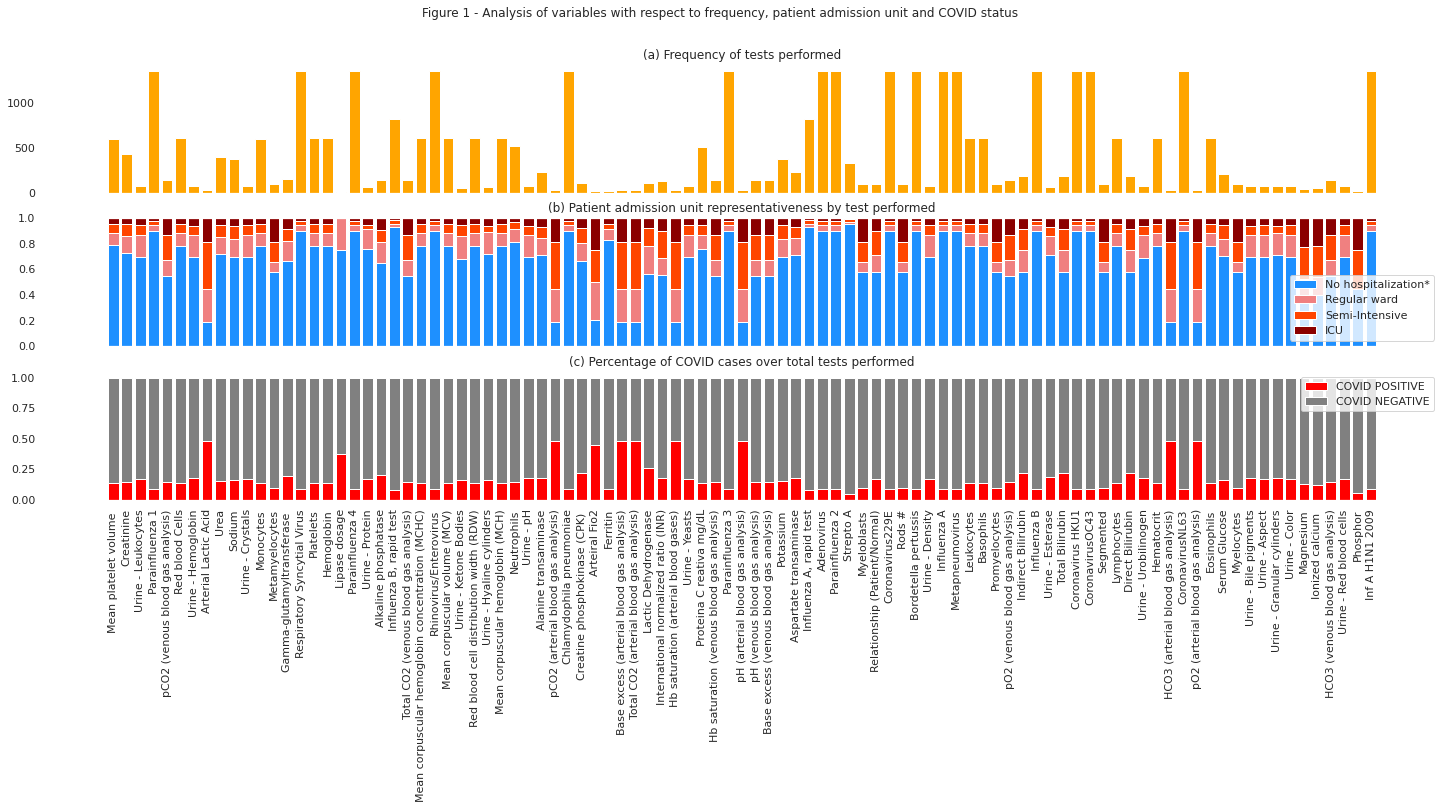

In [ ]:
exams_cols_list = list(exams_cols)
freqExams = df4.shape[0] - df4[exams_cols_list].isnull().sum()

covY = (df4[df4['SARS-Cov-2 exam result']==1].shape[0]
        -df4[df4['SARS-Cov-2 exam result']==1][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
covN = (df4[df4['SARS-Cov-2 exam result']==0].shape[0]
        -df4[df4['SARS-Cov-2 exam result']==0][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())

examsICU = (df4[df4['unit']=='icu'].shape[0]
        -df4[df4['unit']=='icu'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
examsSemiIntesive = (df4[df4['unit']=='semi-intensive'].shape[0]
        -df4[df4['unit']=='semi-intensive'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
examsRegular = (df4[df4['unit']=='regular ward'].shape[0]
        -df4[df4['unit']=='regular ward'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
examsElective = (df4[df4['unit']=='no hospitalization'].shape[0]
        -df4[df4['unit']=='no hospitalization'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())

fig, axs = plt.subplots(3, 1, figsize=(25,8))
fig.patch.set_facecolor('white')

#Frequency plot
pFreq = axs[0].bar(exams_cols_list, freqExams, color='orange', )  
axs[0].set_title("(a) Frequency of tests performed")
axs[0].get_xaxis().set_ticks([])

#Admission units over total tests performed
pElective = axs[1].bar(exams_cols_list, examsElective, color='dodgerblue')
pRegular = axs[1].bar(exams_cols_list, examsRegular, bottom=examsElective,  color='lightcoral')
pSemiIntesive = axs[1].bar(exams_cols_list, examsSemiIntesive, bottom=(examsElective+examsRegular), color='orangered')
pICU = axs[1].bar(exams_cols_list, examsICU, bottom=(examsSemiIntesive+examsElective+examsRegular), color='darkred')
axs[1].set_title("(b) Patient admission unit representativeness by test performed")
axs[1].legend(["No hospitalization*", "Regular ward", "Semi-Intensive", "ICU"], loc="lower right")
axs[1].get_xaxis().set_ticks([])

#Percentage of COVID cases over total tests performed
pCovY = axs[2].bar(exams_cols_list, covY, color='red')
pCovN = axs[2].bar(exams_cols_list, covN, bottom=covY, color='grey')
plt.xticks(exams_cols_list, exams_cols_list, rotation='vertical')
axs[2].set_title("(c) Percentage of COVID cases over total tests performed")
axs[2].legend(["COVID POSITIVE", "COVID NEGATIVE"])

plt.xticks(exams_cols_list, exams_cols_list, rotation='vertical')

plt.subplots_adjust(hspace=0.2) 
fig.suptitle("Figure 1 - Analysis of variables with respect to frequency, patient admission unit and COVID status")
plt.plot()


We first analyze the frequency of each test in the dataset. The first plot in the figure below illustrate it (Figure 1 (a)). There's a high dispersion in the quantity of patients undergoing each test. So we investigated (Figure 1 (b)) the representativeness of patient admission unit for each medical exam. Usually, rarest tests are related to increased complexity of the medical facility. Also, we found on Figure 1 (c) that **rarer tests are related to higher probability of the patient having coronavirus.**



## Presence or abscence of exams (heatmap)

Text(0.5, 1.0, 'Figure 2 - Presence (white) or absense (black) of exams')

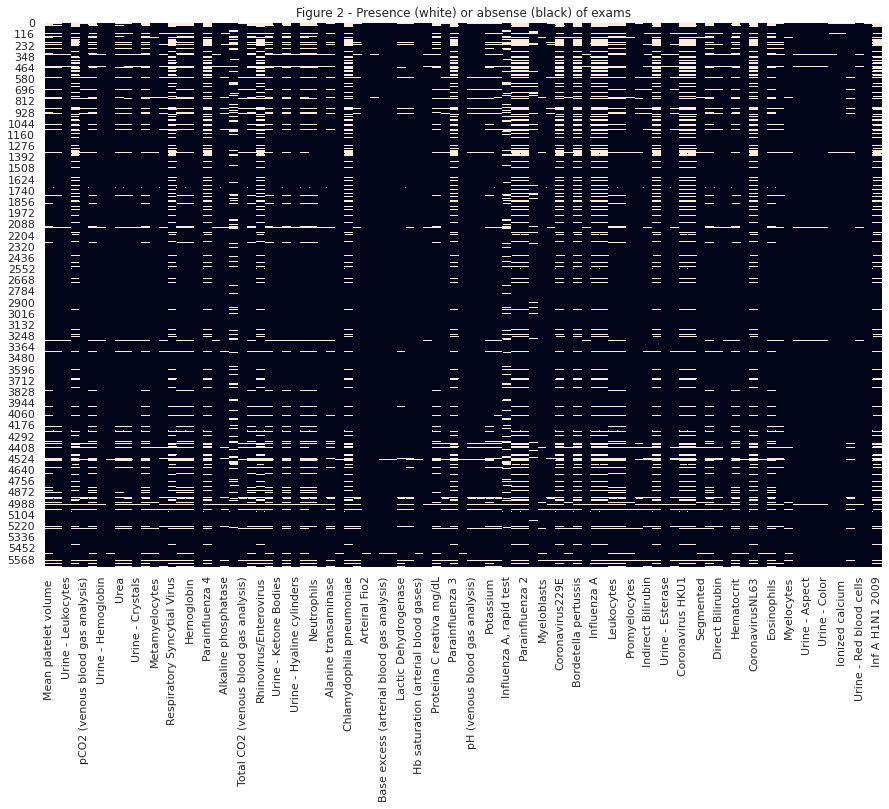

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(exams_performed, cbar=False)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.title("Figure 2 - Presence (white) or absense (black) of exams")

#Dimensionality Reduce - Principal Component Analysis (PCA)

https://datacadamia.com/data_mining/pca#:~:text=Principal%20Component%20Analysis%20(PCA)%20is,scaled%20with%20the%20data%20variance.

The dataset is too big and too sparse. We will use PCA to group exams into principal components (exams that usually are made together)

How many principal components?

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_model = PCA(random_state=42).fit(exams_performed) #random state = 42 fixed every time, fit on df exams_performed

Text(0.5, 1.0, 'Figure 3 - Cummulative explained variance of Principal Components')

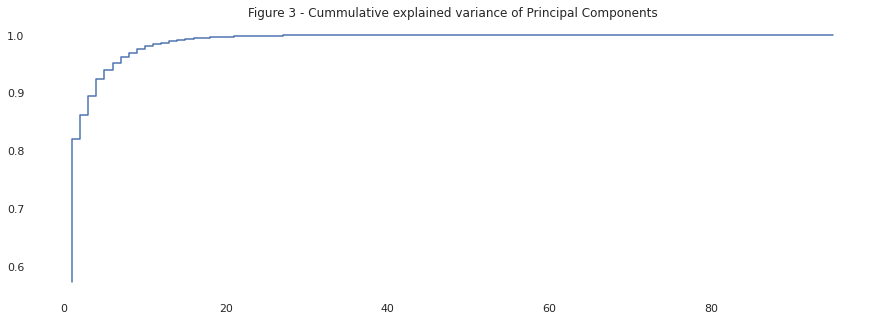

In [ ]:
variances_explained = pca_model.explained_variance_ratio_.cumsum() 
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('white')
plt.step(list(range(1,len(variances_explained)+1)),variances_explained)
plt.title("Figure 3 - Cummulative explained variance of Principal Components")

In [ ]:
variances_explained

array([0.572917  , 0.81943793, 0.8613374 , 0.89507942, 0.9231957 ,
       0.93928328, 0.95186713, 0.96162681, 0.96939537, 0.97623822,
       0.98074265, 0.98391058, 0.98652068, 0.98861847, 0.99061558,
       0.99241818, 0.99400915, 0.99526513, 0.99602214, 0.99660485,
       0.99703795, 0.99743263, 0.99775413, 0.99806262, 0.99833192,
       0.99858522, 0.99879537, 0.99899721, 0.9991534 , 0.99929896,
       0.99943398, 0.99956418, 0.99967093, 0.99976405, 0.99983104,
       0.9998803 , 0.99992725, 0.99995266, 0.99997141, 0.99998598,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

After 6th principal component variance rises slowly. We see that in the plot and in the list. So in the PCA model we choose **n_components = 6**

## Plot the 6 more important Principal Components

In [ ]:
pca_model = PCA(n_components=6, random_state=42).fit(exams_performed) 

Text(0.5, 0.98, 'Figure 4 - Principal Components (PC) explained')

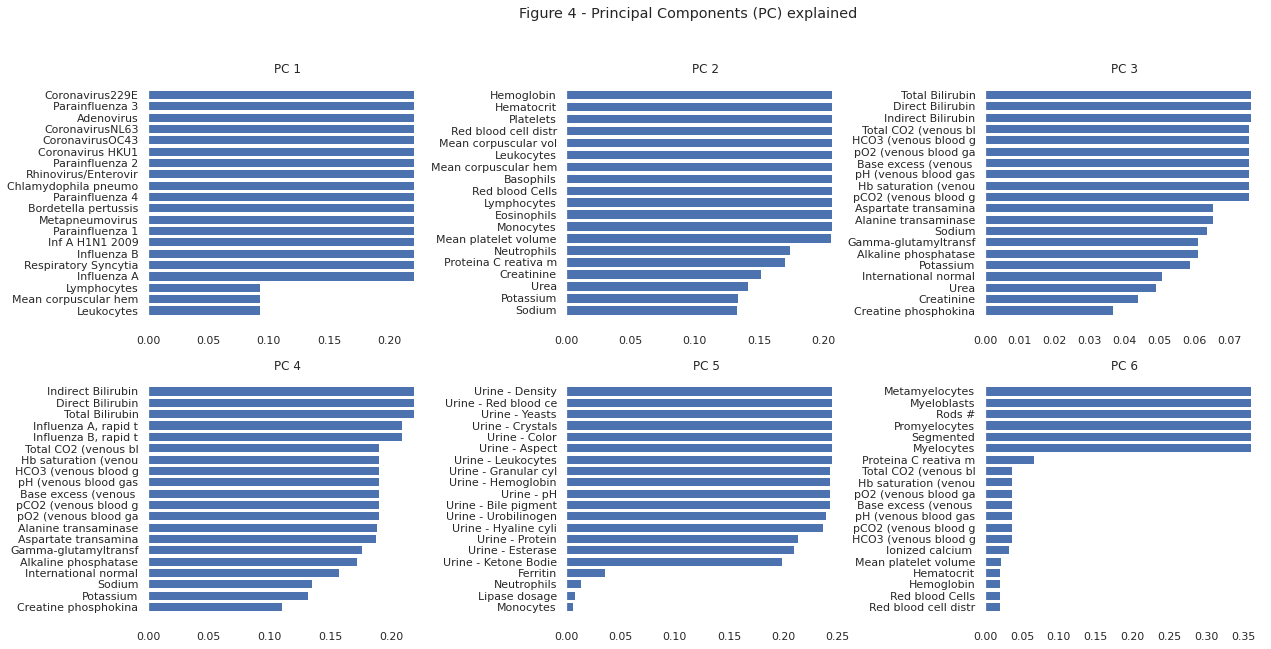

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.patch.set_facecolor((1,1,1))
plt.subplots_adjust(wspace=0.5) 
pc= -1
for i in list(range(2)): #plot lines
  for j in list(range(3)): #plot cols
    pc+=1
    component_feature_explanation = pd.Series(pca_model.components_[pc], index=list(exams_cols)).sort_values()
    axis_truncated = [txt[:20] for txt in component_feature_explanation[-20:].index]
    axs[i, j].barh(axis_truncated, component_feature_explanation[-20:])
    axs[i, j].set_title('PC '+str(pc+1))
fig.suptitle("Figure 4 - Principal Components (PC) explained")


## Interpretation of Principal Components (PC's) (groups)

1. Respiratory viruses test (e.g.: Influenza, Rhinovirus)
2. Regular blood test (red and white cells)
3. Billirubin, enzymes, electrolytes1 and gaseous analysis
4. Same interpretation of 3 (medical expertise would help)
5. Urine tests
6. Unusual Bone marrow cells circulating in blood and segmented parts

Merge PC3 + PC4 , create new group influenza rapid tests  

So the final PCs are:

1. Respiratory Tests 
2. Regular Blood Tests
3. Liver-Kidney-gas Tests (3+4)
4. Urine tests
5. Bone narrow tests
6. Influenza rapid tests (new)


In [ ]:
#Create a new dictionary with the principal components and the exams of each pc.

pcs_vars = {'respiratory': ['Influenza B', 'Respiratory Syncytial Virus', 'Influenza A',
                            'Metapneumovirus', 'Parainfluenza 1', 'Inf A H1N1 2009',
                            'Bordetella pertussis', 'Chlamydophila pneumoniae', 'Coronavirus229E',
                            'Parainfluenza 2', 'Parainfluenza 3', 'CoronavirusNL63',
                            'Rhinovirus/Enterovirus', 'CoronavirusOC43', 'Coronavirus HKU1',
                            'Adenovirus', 'Parainfluenza 4'],
            'regular_blood': ['Proteina C reativa mg/dL',
                              'Neutrophils', 'Mean platelet volume ', 'Monocytes',
                              'Red blood cell distribution width (RDW)', 'Red blood Cells',
                              'Platelets', 'Eosinophils', 'Basophils', 'Leukocytes',
                              'Mean corpuscular hemoglobin (MCH)', 'Mean corpuscular volume (MCV)',
                              'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Lymphocytes',
                              'Hemoglobin', 'Hematocrit'],
            'liver_kidney_gas': ['Creatine phosphokinase\xa0(CPK)\xa0', 
                                 'International normalized ratio (INR)', 
                                 'Alkaline phosphatase', 'Gamma-glutamyltransferase\xa0',
                                 'Alanine transaminase', 'Aspartate transaminase',
                                 'HCO3 (venous blood gas analysis)',
                                 'Hb saturation (venous blood gas analysis)',
                                 'Total CO2 (venous blood gas analysis)',
                                 'pCO2 (venous blood gas analysis)', 'pH (venous blood gas analysis)',
                                 'pO2 (venous blood gas analysis)',
                                 'Base excess (venous blood gas analysis)', 'Total Bilirubin',
                                 'Direct Bilirubin', 'Indirect Bilirubin',
                                 'Sodium', 'Potassium', 'Urea', 'Creatinine'],
            'urine': ['Urine - Ketone Bodies', 'Urine - Esterase', 'Urine - Protein',
                      'Urine - Hyaline cylinders', 'Urine - Urobilinogen',
                      'Urine - Bile pigments', 'Urine - Hemoglobin', 'Urine - pH',
                      'Urine - Granular cylinders', 'Urine - Aspect', 'Urine - Density',
                      'Urine - Color', 'Urine - Red blood cells', 'Urine - Leukocytes',
                      'Urine - Yeasts', 'Urine - Crystals'],
            'bone_narrow_cells': ['Metamyelocytes', 'Myelocytes', 'Promyelocytes', 'Rods #',
                                  'Myeloblasts', 'Segmented'],
            'influenza_rapid': ['Influenza B, rapid test', 'Influenza A, rapid test']}

vars_analyzed = [var for pc in pcs_vars for var in pcs_vars[pc]]
#len(vars_analyzed) == len(set(vars_analyzed)) #sanity check must return true
#len(vars_analyzed) #Output: 77


New dataframe df5, we flag each row (patient) with every group of exams performed  

eg patient 1: resp_tests:0, reg_blood_tests:1 etc...

In [ ]:
df5 = df4.copy()
#Here we create columns to flag the group of tests performed
for pc in pcs_vars.keys():
  df5[pc+"_tests"] = df5.apply(lambda x: 0 if x[pcs_vars[pc]].isnull().all() else 1,axis=1)


## What about the exams not included in the above 6 groups?

[]

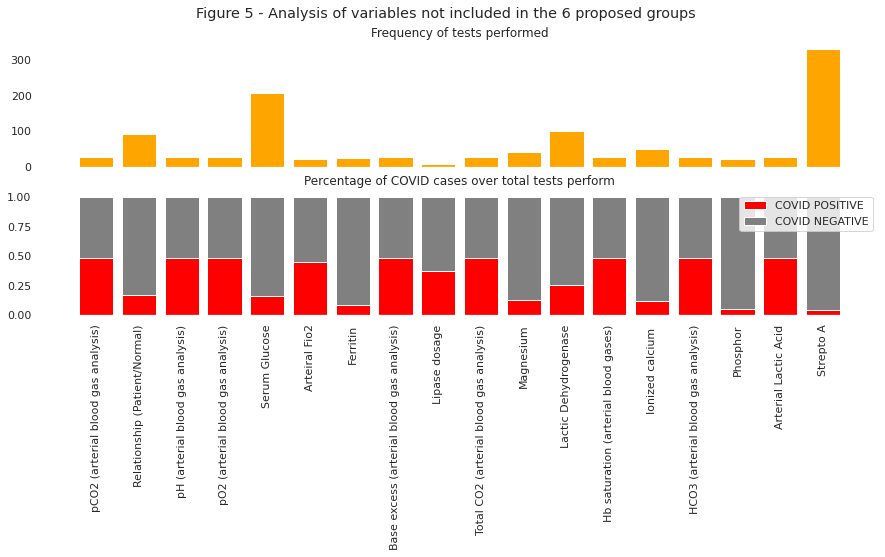

In [ ]:
exams_not_included = list(set(exams_performed.columns) - set(vars_analyzed)) #keep only tests that are not in the PCs

freqExams = df5.shape[0] - df5[exams_not_included].isnull().sum()
covY = (df5[df5['SARS-Cov-2 exam result']==1].shape[0]
        -df5[df5['SARS-Cov-2 exam result']==1][exams_not_included].isnull().sum())/(df5.shape[0] - df5[exams_not_included].isnull().sum())
covN = (df5[df5['SARS-Cov-2 exam result']==0].shape[0]
        -df5[df5['SARS-Cov-2 exam result']==0][exams_not_included].isnull().sum())/(df5.shape[0] - df5[exams_not_included].isnull().sum())


fig, axs = plt.subplots(2, 1, figsize=(15,5))
fig.patch.set_facecolor((1,1,1))


pFreq = axs[0].bar(exams_not_included, freqExams, color='orange', )  
pCovY = axs[1].bar(exams_not_included, covY, color='red')
pCovN = axs[1].bar(exams_not_included, covN, bottom=covY, color='grey')
axs[0].get_xaxis().set_ticks([])
plt.xticks(exams_not_included, exams_not_included, rotation='vertical')
axs[0].set_title("Frequency of tests performed")
axs[1].set_title("Percentage of COVID cases over total tests perform")
plt.legend(["COVID POSITIVE", "COVID NEGATIVE"])
plt.subplots_adjust(hspace=0.2) 

fig.suptitle("Figure 5 - Analysis of variables not included in the 6 proposed groups")
plt.plot()


Usually very low frequency tests.


Text(0.5, 1.0, 'Figure 6 - Figure 2 reordered by group of exams')

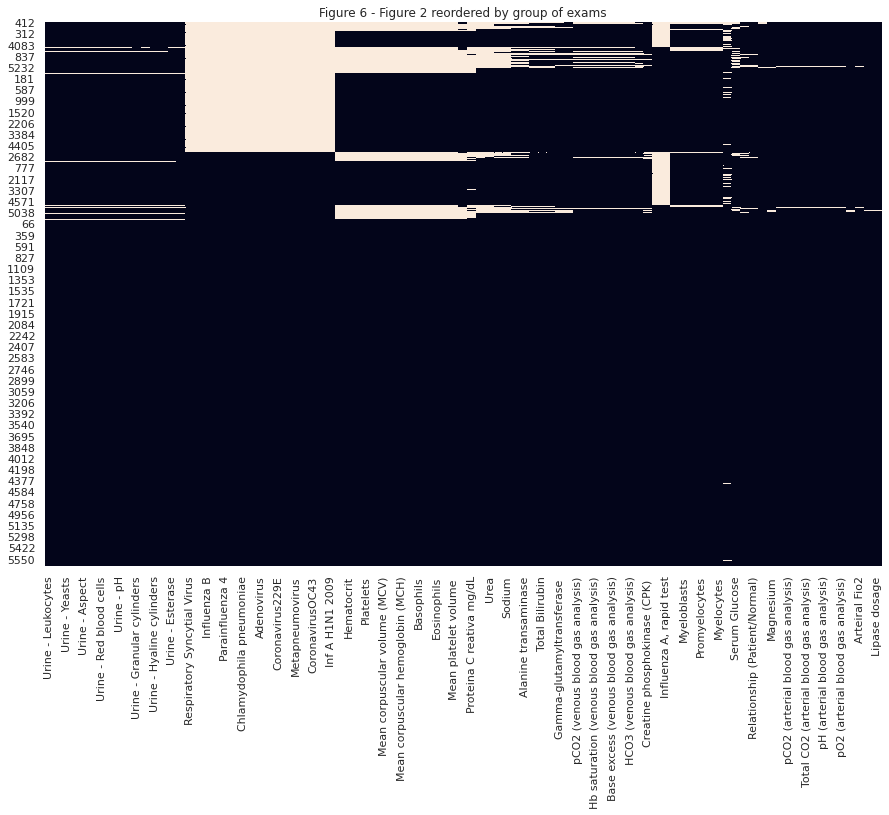

In [ ]:
inv_pcs_vars = {}
for pc in pcs_vars:
    for var in pcs_vars[pc]:
        inv_pcs_vars[var]=pc

cols_sorted = pd.DataFrame(data = exams_performed.sum(), columns=["count"]).merge(
    pd.DataFrame(data = pd.Series(inv_pcs_vars), columns=["pc"]), how="left", left_index=True, 
    right_index=True).sort_values(by=["pc","count"],ascending=False)

rows_order_by = cols_sorted.reset_index().groupby("pc").first().sort_values(by=["count"],ascending=False)["index"].to_list()
#rows_order_by = ['Respiratory Syncytial Virus', 'Hematocrit', 'Influenza B, rapid test','Creatinine', 'Segmented', 'Urine - Red blood cells']

exams_performed_sorted = exams_performed[cols_sorted.index].sort_values(by=rows_order_by, ascending=False)

plt.figure(figsize=(15,10))
fig.patch.set_facecolor((1,1,1))

sns.heatmap(exams_performed_sorted, cbar=False)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.title("Figure 6 - Figure 2 reordered by group of exams")


## Coocurences of tests + admission unit (ICU etc)

Covid positive patients have done slightly more non-respiratory tests then COVID negative people. Comparing admission units, admitted patients underwent significantly more exams then non hospitalized ones.

In [ ]:
def cooc_matrix(dataset):
  cooc =  dataset.T.dot(dataset)/dataset.shape[0]
  cooc_format = cooc.style.format("{:.1%}")
  return cooc_format

tests_cols = ['respiratory_tests', 'regular_blood_tests', 
              'liver_kidney_gas_tests', 'urine_tests', 'bone_narrow_cells_tests',
              'influenza_rapid_tests']

cooc_tests_covid_neg = cooc_matrix(df5[df5['SARS-Cov-2 exam result']==0][tests_cols]) #exams on negative patients
cooc_tests_covid_poz = cooc_matrix(df5[df5['SARS-Cov-2 exam result']==1][tests_cols]) #exams on positive patients
cooc_tests_icu = cooc_matrix(df5[df5['unit']=='icu'][tests_cols]) #exams on ICU patients
cooc_tests_semi = cooc_matrix(df5[df5['unit']=='semi-intensive'][tests_cols])
cooc_tests_reg = cooc_matrix(df5[df5['unit']=='regular ward'][tests_cols])
cooc_tests_ele = cooc_matrix(df5[df5['unit']=='no hospitalization'][tests_cols])


In [ ]:
cooc_tests_covid_neg

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,24.4%,6.2%,5.0%,0.6%,1.1%,4.9%
regular_blood_tests,6.2%,10.3%,7.6%,0.9%,1.7%,3.4%
liver_kidney_gas_tests,5.0%,7.6%,7.6%,0.8%,1.4%,2.5%
urine_tests,0.6%,0.9%,0.8%,1.1%,0.2%,0.3%
bone_narrow_cells_tests,1.1%,1.7%,1.4%,0.2%,1.7%,0.7%
influenza_rapid_tests,4.9%,3.4%,2.5%,0.3%,0.7%,14.9%


In [ ]:
cooc_tests_covid_poz

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,20.1%,9.3%,9.0%,1.3%,0.7%,3.4%
regular_blood_tests,9.3%,15.1%,12.0%,1.6%,1.6%,4.1%
liver_kidney_gas_tests,9.0%,12.0%,12.0%,1.6%,1.4%,3.0%
urine_tests,1.3%,1.6%,1.6%,2.2%,0.2%,0.5%
bone_narrow_cells_tests,0.7%,1.6%,1.4%,0.2%,1.6%,0.5%
influenza_rapid_tests,3.4%,4.1%,3.0%,0.5%,0.5%,11.1%


In [ ]:
cooc_tests_icu

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,80.5%,53.7%,46.3%,7.3%,34.1%,24.4%
regular_blood_tests,53.7%,70.7%,53.7%,9.8%,43.9%,19.5%
liver_kidney_gas_tests,46.3%,53.7%,53.7%,7.3%,34.1%,12.2%
urine_tests,7.3%,9.8%,7.3%,9.8%,7.3%,4.9%
bone_narrow_cells_tests,34.1%,43.9%,34.1%,7.3%,43.9%,14.6%
influenza_rapid_tests,24.4%,19.5%,12.2%,4.9%,14.6%,31.7%


In [ ]:
cooc_tests_semi

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,82.0%,68.0%,66.0%,6.0%,24.0%,36.0%
regular_blood_tests,68.0%,84.0%,80.0%,10.0%,30.0%,36.0%
liver_kidney_gas_tests,66.0%,80.0%,80.0%,10.0%,26.0%,32.0%
urine_tests,6.0%,10.0%,10.0%,10.0%,4.0%,2.0%
bone_narrow_cells_tests,24.0%,30.0%,26.0%,4.0%,30.0%,18.0%
influenza_rapid_tests,36.0%,36.0%,32.0%,2.0%,18.0%,48.0%


In [ ]:
cooc_tests_reg

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,73.4%,59.5%,58.2%,13.9%,6.3%,12.7%
regular_blood_tests,59.5%,74.7%,72.2%,13.9%,10.1%,16.5%
liver_kidney_gas_tests,58.2%,72.2%,72.2%,13.9%,8.9%,15.2%
urine_tests,13.9%,13.9%,13.9%,15.2%,1.3%,2.5%
bone_narrow_cells_tests,6.3%,10.1%,8.9%,1.3%,10.1%,2.5%
influenza_rapid_tests,12.7%,16.5%,15.2%,2.5%,2.5%,21.5%


In [ ]:
cooc_tests_ele

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,22.3%,4.8%,3.8%,0.3%,0.5%,4.2%
regular_blood_tests,4.8%,8.7%,6.1%,0.6%,1.0%,2.9%
liver_kidney_gas_tests,3.8%,6.1%,6.1%,0.5%,0.9%,2.0%
urine_tests,0.3%,0.6%,0.5%,0.9%,0.1%,0.2%
bone_narrow_cells_tests,0.5%,1.0%,0.9%,0.1%,1.0%,0.4%
influenza_rapid_tests,4.2%,2.9%,2.0%,0.2%,0.4%,14.0%


#Classification

**Strategy:**

**What we have found in EDA**
- There are many missing (NaN) values in the dataset.
- We have 6 groups of tests that usually are done together (PCA)
- co-occurence between group of tests is strongly depending on the severity 

**Strategy:**
 - Create separate models for each group of tests.

**Metrics**  

[Metrics explained here](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/#:~:text=80%25%20accurate.&text=Precision%20%2D%20Precision%20is%20the%20ratio,the%20total%20predicted%20positive%20observations.&text=F1%20score%20%2D%20F1%20Score%20is,and%20false%20negatives%20into%20account.)<br>


- Accuracy: $\frac{TP+TN}{TP+FP+FN+TN}$  
Ratio of correctly predicted observation to the total observations
<br>
<br>

- Precision: $\frac{TP}{TP+FP}$  
<br>
Ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all patients that labeled as positive, how many actually are positive?
<br>
<br>

- Recall: $\frac{TP}{TP+FN}$
<br>  
The question recall answers is: Of all the patients that truly are positive, how many did we label as positive?
<br>
<br>

- F1 score: $\frac{2*Recall*Precision}{Recall + Precision}$
<br>
F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.
<br>  
**F1 score is more useful when the dataset is heavily imbalanced**

- We choose **F1** as the metric for our models.


In [ ]:
#import machine learning libraries

#Data split and hyperparameter search
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


#Classifiers
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


## - Classifications on blood tests (PC2)


In [ ]:
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['regular_blood']
df_blood = df5[selected_vars].dropna() #Shape: (420, 19)

X = df_blood[pcs_vars['regular_blood']+['Patient age quantile']] #predictors/dependent
y = df_blood['SARS-Cov-2 exam result'] #target variable
strat = df_blood['SARS-Cov-2 exam result'].astype(str) + df_blood['unit'] #stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = strat, shuffle=True, random_state=42) #split 70-30
#X_train.shape: (294, 17)
#X_test.shape: (126, 17)

model_blood_scores_f1 = []
model_blood_scores_recall = []

In [ ]:
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['urine']
df_urine = df5[selected_vars].dropna()

print("urine Test dataset size (rows,cols): ",df_urine.shape)

selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['respiratory']
df_resp = df5[selected_vars].dropna()

print("resp Test dataset size (rows,cols): ",df_resp.shape)

selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['bone_narrow_cells']
df_bone = df5[selected_vars].dropna()

print("bone narrow Test dataset size (rows,cols): ",df_bone.shape)

selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['bone_narrow_cells']
df_bone = df5[selected_vars].dropna()

print("bone narrow Test dataset size (rows,cols): ",df_bone.shape)

selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['liver_kidney_gas']
df_liver = df5[selected_vars].dropna()

print("liver Test dataset size (rows,cols): ",df_liver.shape)



urine Test dataset size (rows,cols):  (40, 19)
resp Test dataset size (rows,cols):  (1352, 20)
bone narrow Test dataset size (rows,cols):  (97, 9)
bone narrow Test dataset size (rows,cols):  (97, 9)
liver Test dataset size (rows,cols):  (30, 23)


In [ ]:
print("Blood Test dataset size (rows,cols): ",df_blood.shape)

Blood Test dataset size (rows,cols):  (420, 19)


### Dummy Classifier

- Dummy classifier classifies all cases as negative (0). Thus it gives great accuracy but low f1-score (avg). The good accuracy score is because our dataset is largely imbalanced (109 negative cases, 17 positive)

In [ ]:
dummy_most_freq_clf = DummyClassifier(strategy="most_frequent")
dummy_most_freq_clf.fit(X_train, y_train)
y_dummy_most_freq_pred = dummy_most_freq_clf.predict(X_test)

print("Classification report for Dummy 'Most Frequent' Classifier")
print(classification_report(y_test, y_dummy_most_freq_pred))

Classification report for Dummy 'Most Frequent' Classifier
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       109
           1       0.00      0.00      0.00        17

    accuracy                           0.87       126
   macro avg       0.43      0.50      0.46       126
weighted avg       0.75      0.87      0.80       126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Confusion Matrix:
<br>
In binary classification, the count of true negatives is $C_{0,0}$
, false negatives is $C_{1,0}$
, true positives is $C_{1,1}$
  and false positives is $C_{0,1}$.

https://www.dataschool.io/content/images/2015/01/confusion_matrix2.png


In [ ]:
#sanity check
print(y_test.shape[0])
print(y_dummy_most_freq_pred.shape[0])

126
126


In [ ]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_dummy_most_freq_pred).ravel()
print(confusion_matrix(y_test, y_dummy_most_freq_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

[[109   0]
 [ 17   0]]
True Negative (TN) = 109 , False Positive (FP) = 0, False  Negative (FN) = 17, True Positive (TP) = 0


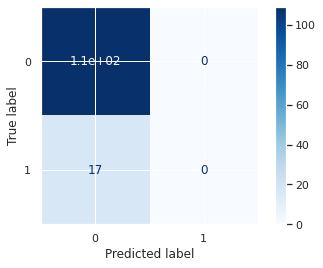

In [ ]:
disp = plot_confusion_matrix(dummy_most_freq_clf, X_test, y_test,
                                 cmap=plt.cm.Blues)
                                 
plt.show()

### Decision Tree Classifier

In [ ]:
#hyper parameter tuning using GridSearch

criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]

parameters = {"criterion" : criterion,
              "max_depth" : max_depth}

clf = tree.DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search =grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on training set: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

Best estimator is:{'criterion': 'entropy', 'max_depth': 8}
F1-Score (macro avg) on training set: 68.74%


In [ ]:
print("\nClassification report for Decision Trees on test")
print(classification_report(y_test, y_pred))


#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Decision Trees classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))


Classification report for Decision Trees on test
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       109
           1       0.46      0.65      0.54        17

    accuracy                           0.85       126
   macro avg       0.70      0.76      0.72       126
weighted avg       0.88      0.85      0.86       126

Decision Trees classifier Confusion Matrix: 
 [[96 13]
 [ 6 11]]
True Negative (TN) = 96 , False Positive (FP) = 13, False  Negative (FN) = 6, True Positive (TP) = 11


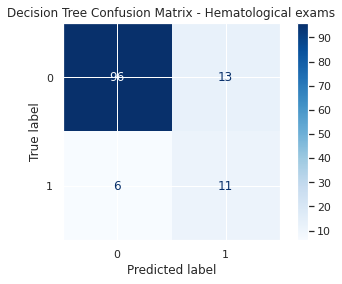

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix - Hematological exams")                         
plt.show()

In [ ]:
model_blood_scores_f1.append(f1_score(y_test, y_pred, average='macro'))
model_blood_scores_recall.append(recall_score(y_test, y_pred, average='macro'))

In [ ]:
#!pip install graphviz
#!pip install pydotplus

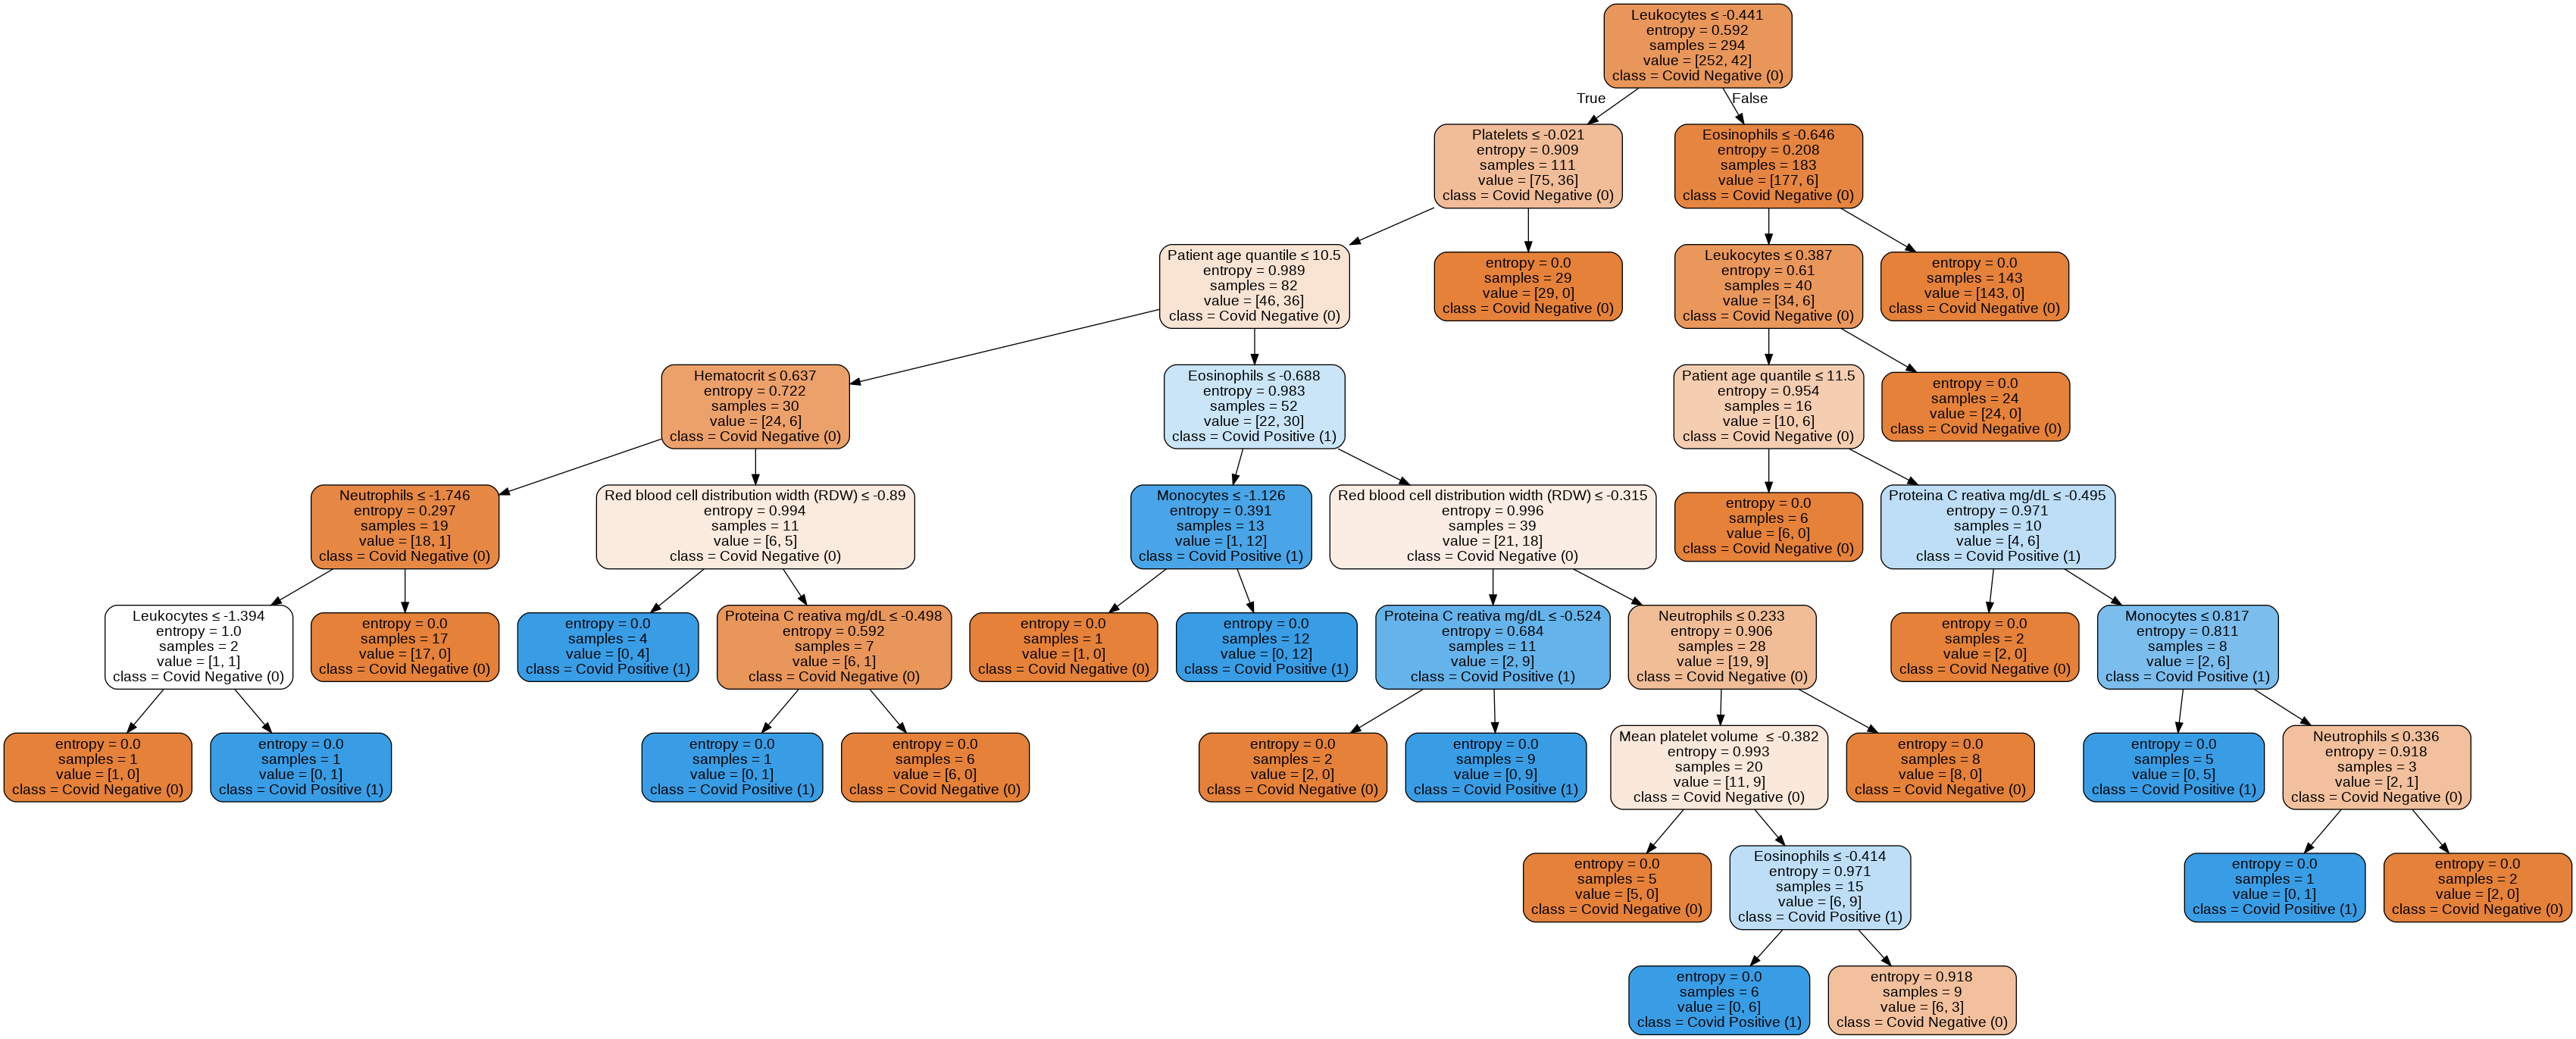

In [ ]:
#visualize tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(grid_search.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=pcs_vars['regular_blood']+['Patient age quantile'],class_names=['Covid Negative (0)','Covid Positive (1)'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('covidDT.png')
Image(graph.create_png())


### KNN (K-nearest neighbors) Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {"n_neighbors" : [3,4,5,8,10,15,19],
              'weights' : ['uniform','distance'],
              'metric' : ['euclidean','manhattan']}
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search =grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))


y_pred = grid_search.best_estimator_.predict(X_test)


print("\nClassification report for KNN clasifier on test")
print(classification_report(y_test, y_pred))


#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("KNN Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

Best estimator is:{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
F1-Score (macro avg) on train: 64.60%

Classification report for KNN clasifier on test
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       109
           1       0.18      0.12      0.14        17

    accuracy                           0.81       126
   macro avg       0.53      0.52      0.52       126
weighted avg       0.78      0.81      0.79       126

KNN Confusion Matrix: 
 [[100   9]
 [ 15   2]]
True Negative (TN) = 100 , False Positive (FP) = 9, False  Negative (FN) = 15, True Positive (TP) = 2


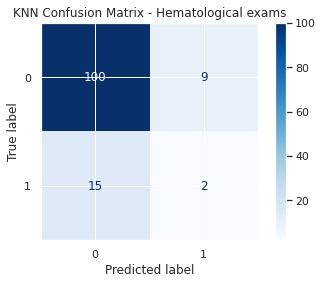

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("KNN Confusion Matrix - Hematological exams")                         
plt.show()

In [ ]:
model_blood_scores_f1.append(f1_score(y_test, y_pred, average='macro'))
model_blood_scores_recall.append(recall_score(y_test, y_pred, average='macro'))

### SVM classifier

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.1, 1, 10],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = svm.SVC(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))


y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for SVM on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'C': 10, 'class_weight': {1: 2}, 'kernel': 'linear'}
F1-Score (macro avg) on train: 75.47%

Classification report for SVM on test
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       109
           1       0.48      0.82      0.61        17

    accuracy                           0.86       126
   macro avg       0.73      0.84      0.76       126
weighted avg       0.90      0.86      0.87       126



In [ ]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("SVM classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

SVM classifier Confusion Matrix: 
 [[94 15]
 [ 3 14]]
True Negative (TN) = 94 , False Positive (FP) = 15, False  Negative (FN) = 3, True Positive (TP) = 14


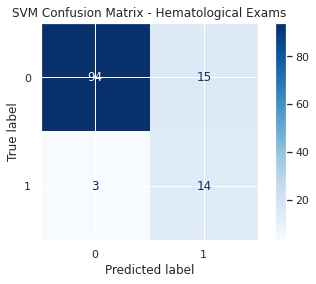

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix - Hematological Exams")                         
plt.show()

In [ ]:
model_blood_scores_f1.append(f1_score(y_test, y_pred, average='macro'))
model_blood_scores_recall.append(recall_score(y_test, y_pred, average='macro'))

## Ensemble Models

- Feature Importance

### Random Forest Classifier

In [ ]:
parameters = {'n_estimators': [50, 100, 200], 
              'max_depth': [3, 5, 10, 15],
              'max_features': [0.6, 0.8, 1.0],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Random Forest on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'class_weight': {1: 5}, 'max_depth': 3, 'max_features': 0.6, 'n_estimators': 200}
F1-Score (macro avg) on train: 73.72%

Classification report for Random Forest on test
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       109
           1       0.44      0.71      0.55        17

    accuracy                           0.84       126
   macro avg       0.70      0.78      0.72       126
weighted avg       0.88      0.84      0.86       126



In [ ]:
model_blood_scores_f1.append(f1_score(y_test, y_pred, average='macro'))
model_blood_scores_recall.append(recall_score(y_test, y_pred, average='macro'))

In [ ]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Random Forest Classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

Random Forest Classifier Confusion Matrix: 
 [[94 15]
 [ 5 12]]
True Negative (TN) = 94 , False Positive (FP) = 15, False  Negative (FN) = 5, True Positive (TP) = 12


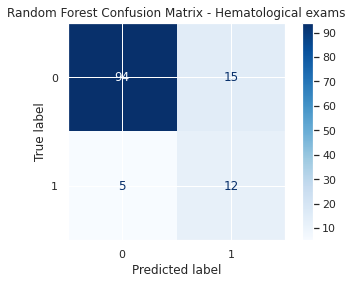

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix - Hematological exams")                         
plt.show()

### Adaboost

In [ ]:
parameters = {'n_estimators': [5, 10, 20, 30], 
              'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier(max_depth=1, class_weight="balanced"),
                                 DecisionTreeClassifier(max_depth=3, class_weight="balanced")],
              'learning_rate': [0.01, 0.1, 1.0]
              }

clf = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for AdaBoost on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.01, 'n_estimators': 30}
F1-Score (macro avg) on train: 73.19%

Classification report for AdaBoost on test
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       109
           1       0.67      0.59      0.62        17

    accuracy                           0.90       126
   macro avg       0.80      0.77      0.79       126
weighted avg       0.90      0.90      0.90       126



In [ ]:
model_blood_scores_f1.append(f1_score(y_test, y_pred, average='macro'))
model_blood_scores_recall.append(recall_score(y_test, y_pred, average='macro'))

In [ ]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Adaboost (on Decision Trees) Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

Adaboost (on Decision Trees) Confusion Matrix: 
 [[104   5]
 [  7  10]]
True Negative (TN) = 104 , False Positive (FP) = 5, False  Negative (FN) = 7, True Positive (TP) = 10


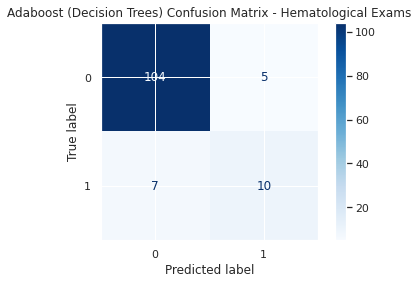

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("Adaboost (Decision Trees) Confusion Matrix - Hematological Exams")                         
plt.show()

### Models F1 score table

In [ ]:
model_names=["Decision Tree","KNN","SVM","Gradient Boost","Random Forest","Adaboost"]
model_summary_f1=pd.DataFrame(zip(model_names,model_blood_scores_f1),columns=["Model Name","F1 Score (macro)"]).sort_values(["F1 Score (macro)"],ascending=False)
model_summary_f1.reset_index(drop=True)


,Model Name,F1 Score (macro)
0,Adaboost,0.785227
1,SVM,0.760659
2,Random Forest,0.724650
3,Decision Tree,0.723269
4,Gradient Boost,0.660011
5,KNN,0.517857


In [ ]:
model_summary_recall = pd.DataFrame(zip(model_names,model_blood_scores_recall),columns=["Model Name","Recall (macro)"]).sort_values(["F1 Score (macro)"],ascending=False)
model_summary_recall.reset_index(drop=True)

KeyError: ignored

- Baseline F1 score (Dummy CLassifier): 0.46 

- All models (except KNN) perform better.




## Classifications on Respiratory Viruses Tests (PC1)

In [ ]:
resp_test_scores = []

In [ ]:
#select variables (tests) that are in the Respiratory Viruses Test group
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['respiratory']
df_respiratory = df5[selected_vars].dropna() #Shape: (420, 19)

X = df_respiratory[pcs_vars['respiratory']+['Patient age quantile']]
y = df_respiratory['SARS-Cov-2 exam result']
strat = df_respiratory['SARS-Cov-2 exam result'].astype(str) + df_respiratory['unit'] #stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=strat, shuffle=True, random_state=42)

In [ ]:
print("Respiratory dataset size (rows,cols): ",df_respiratory.shape)

Respiratory dataset size (rows,cols):  (1352, 20)


In [ ]:
df_respiratory.head()

,SARS-Cov-2 exam result,unit,Patient age quantile,Influenza B,Respiratory Syncytial Virus,Influenza A,Metapneumovirus,Parainfluenza 1,Inf A H1N1 2009,Bordetella pertussis,Chlamydophila pneumoniae,Coronavirus229E,Parainfluenza 2,Parainfluenza 3,CoronavirusNL63,Rhinovirus/Enterovirus,CoronavirusOC43,Coronavirus HKU1,Adenovirus,Parainfluenza 4
1,0,no hospitalization,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,no hospitalization,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0,semi-intensive,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,no hospitalization,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0,no hospitalization,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Training dataset size: ",X_train.shape)
print("Test dataset size: ",X_test.shape)

Training dataset size:  (946, 18)
Test dataset size:  (406, 18)


### Dummy Classifier

In [ ]:
dummy_most_freq_clf = DummyClassifier(strategy="most_frequent")
dummy_most_freq_clf.fit(X_train, y_train)
y_dummy_most_freq_pred = dummy_most_freq_clf.predict(X_test)

print("Classification report for Dummy 'Most Frequent' Classifier")
print(classification_report(y_test, y_dummy_most_freq_pred))

Classification report for Dummy 'Most Frequent' Classifier
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       372
           1       0.00      0.00      0.00        34

    accuracy                           0.92       406
   macro avg       0.46      0.50      0.48       406
weighted avg       0.84      0.92      0.88       406



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_dummy_most_freq_pred).ravel()
print("Dummy Clasifier Confusion Matrix: \n",confusion_matrix(y_test, y_dummy_most_freq_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

Dummy Clasifier Confusion Matrix: 
 [[372   0]
 [ 34   0]]
True Negative (TN) = 372 , False Positive (FP) = 0, False  Negative (FN) = 34, True Positive (TP) = 0


### Decision Trees

In [ ]:
#hyper parameter tuning using GridSearch

criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]

parameters = {"criterion" : criterion,
              "max_depth" : max_depth}

clf = tree.DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search =grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on training set: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Decision Trees on test")
print(classification_report(y_test, y_pred))


#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Decision Trees classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}\n".format(tn,fp,fn,tp))

resp_test_scores.append(f1_score(y_test, y_pred, average='macro'))

Best estimator is:{'criterion': 'gini', 'max_depth': 4}
F1-Score (macro avg) on training set: 47.85%

Classification report for Decision Trees on test
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       372
           1       0.00      0.00      0.00        34

    accuracy                           0.92       406
   macro avg       0.46      0.50      0.48       406
weighted avg       0.84      0.92      0.88       406

Decision Trees classifier Confusion Matrix: 
 [[372   0]
 [ 34   0]]
True Negative (TN) = 372 , False Positive (FP) = 0, False  Negative (FN) = 34, True Positive (TP) = 0



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


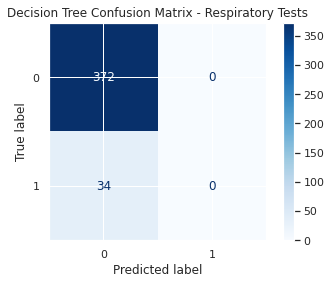

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix - Respiratory Tests")                         
plt.show()

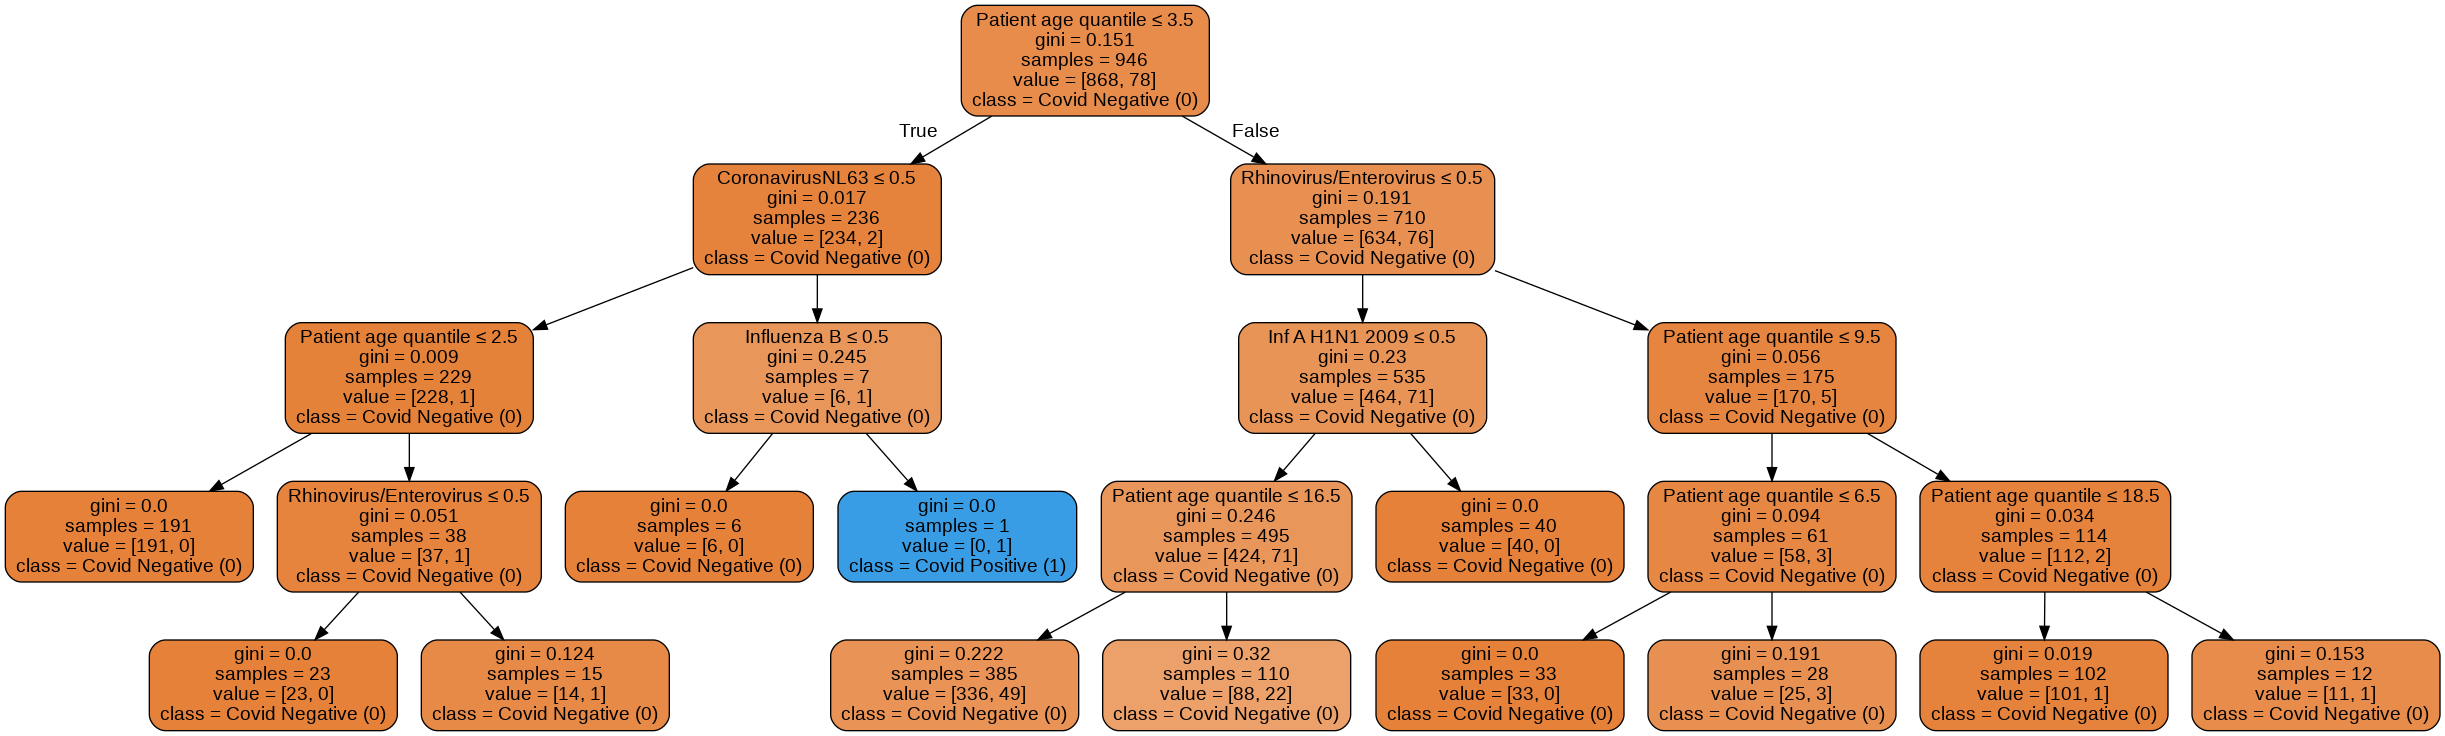

In [ ]:
#visualize tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(grid_search.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=pcs_vars['respiratory']+['Patient age quantile'],class_names=['Covid Negative (0)','Covid Positive (1)'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('covidDT.png')
Image(graph.create_png())


###KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {"n_neighbors" : [3,4,5,8,10,15,19],
              'weights' : ['uniform','distance'],
              'metric' : ['euclidean','manhattan']}
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search =grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))


y_pred = grid_search.best_estimator_.predict(X_test)


print("\nClassification report for KNN clasifier on test")
print(classification_report(y_test, y_pred))


#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("KNN Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

resp_test_scores.append(f1_score(y_test, y_pred, average='macro'))

Best estimator is:{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
F1-Score (macro avg) on train: 51.51%

Classification report for KNN clasifier on test
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       372
           1       0.00      0.00      0.00        34

    accuracy                           0.92       406
   macro avg       0.46      0.50      0.48       406
weighted avg       0.84      0.92      0.88       406

KNN Confusion Matrix: 
 [[372   0]
 [ 34   0]]
True Negative (TN) = 372 , False Positive (FP) = 0, False  Negative (FN) = 34, True Positive (TP) = 0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


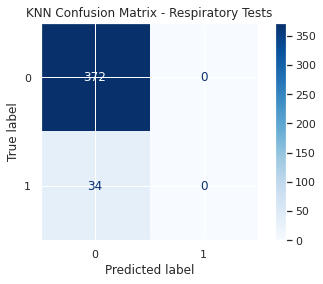

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("KNN Confusion Matrix - Respiratory Tests")                         
plt.show()

### SVM CLassifier

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.1, 1, 10],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = svm.SVC(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for SVM on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("SVM classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

resp_test_scores.append(f1_score(y_test, y_pred, average='macro'))

Best estimator is:{'C': 10, 'class_weight': {1: 5}, 'kernel': 'linear'}
F1-Score (macro avg) on train: 54.89%

Classification report for SVM on test
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       372
           1       0.21      0.53      0.30        34

    accuracy                           0.79       406
   macro avg       0.58      0.67      0.59       406
weighted avg       0.89      0.79      0.83       406

SVM classifier Confusion Matrix: 
 [[303  69]
 [ 16  18]]
True Negative (TN) = 303 , False Positive (FP) = 69, False  Negative (FN) = 16, True Positive (TP) = 18


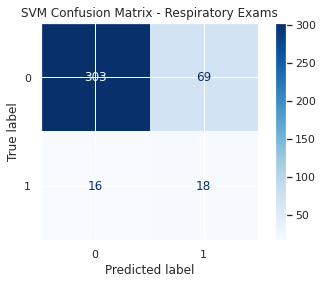

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix - Respiratory Exams")                         
plt.show()

## Ensemble Models

### Gradient Boosting Classifier

In [ ]:
parameters = {'n_estimators': [25,50, 100, 150, 200], 
              'max_depth': [3, 5, 10, 15,20,25],
              'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]
              }
model = GradientBoostingClassifier()
grid_search = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Gradient Boosting Classifier on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Gradient Boosting Classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

resp_test_scores.append(f1_score(y_test, y_pred, average='macro'))


Best estimator is:{'learning_rate': 0.5, 'max_depth': 20, 'n_estimators': 25}
F1-Score (macro avg) on train: 47.85%

Classification report for Gradient Boosting Classifier on test
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       372
           1       0.33      0.03      0.05        34

    accuracy                           0.91       406
   macro avg       0.63      0.51      0.50       406
weighted avg       0.87      0.91      0.88       406

Gradient Boosting Classifier Confusion Matrix: 
 [[370   2]
 [ 33   1]]
True Negative (TN) = 370 , False Positive (FP) = 2, False  Negative (FN) = 33, True Positive (TP) = 1


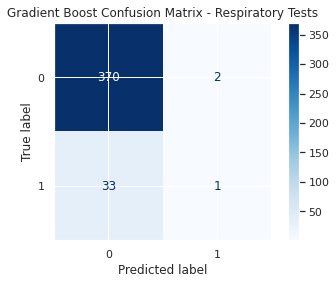

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("Gradient Boost Confusion Matrix - Respiratory Tests")                         
plt.show()

### Random Forest Classifier

In [ ]:
parameters = {'n_estimators': [50, 100, 200], 
              'max_depth': [3, 5, 10, 15],
              'max_features': [0.6, 0.8, 1.0],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Random Forest on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Random Forest Classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

resp_test_scores.append(f1_score(y_test, y_pred, average='macro'))

Best estimator is:{'class_weight': {1: 5}, 'max_depth': 5, 'max_features': 0.6, 'n_estimators': 200}
F1-Score (macro avg) on train: 57.77%

Classification report for Random Forest on test
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       372
           1       0.33      0.15      0.20        34

    accuracy                           0.90       406
   macro avg       0.63      0.56      0.58       406
weighted avg       0.88      0.90      0.89       406

Random Forest Classifier Confusion Matrix: 
 [[362  10]
 [ 29   5]]
True Negative (TN) = 362 , False Positive (FP) = 10, False  Negative (FN) = 29, True Positive (TP) = 5


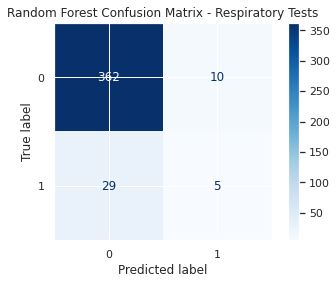

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix - Respiratory Tests")                         
plt.show()

### Adaboost

In [ ]:
parameters = {'n_estimators': [5, 10, 20, 30], 
              'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier(max_depth=1, class_weight="balanced"),
                                 DecisionTreeClassifier(max_depth=3, class_weight="balanced")],
              'learning_rate': [0.01, 0.1, 1.0]
              }

clf = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for AdaBoost on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Adaboost (on Decision Trees) Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))

resp_test_scores.append(f1_score(y_test, y_pred, average='macro'))

Best estimator is:{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 1.0, 'n_estimators': 20}
F1-Score (macro avg) on train: 51.15%

Classification report for AdaBoost on test
              precision    recall  f1-score   support

           0       0.98      0.59      0.74       372
           1       0.16      0.85      0.27        34

    accuracy                           0.61       406
   macro avg       0.57      0.72      0.50       406
weighted avg       0.91      0.61      0.70       406

Adaboost (on Decision Trees) Confusion Matrix: 
 [[220 152]
 [  5  29]]
True Nega

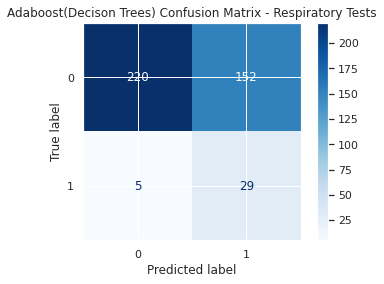

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,
                                values_format = 'd',
                                 cmap=plt.cm.Blues)
plt.title("Adaboost(Decison Trees) Confusion Matrix - Respiratory Tests")                         
plt.show()

###Models F1 score table

In [ ]:
resp_test_scores

[0.4781491002570694,
 0.4781491002570694,
 0.5872552654555022,
 0.5044463818657368,
 0.5764838045309867,
 0.5033929336605508]

In [ ]:
model_names=["Decision Tree","KNN","SVM","Gradient Boost","Random Forest","Adaboost"]
model_summary=pd.DataFrame(zip(model_names,resp_test_scores),columns=["Model Name","F1 Score (macro)"]).sort_values(["F1 Score (macro)"],ascending=False)
model_summary.reset_index(drop=True)

,Model Name,F1 Score (macro)
0,SVM,0.587255
1,Random Forest,0.576484
2,Gradient Boost,0.504446
3,Adaboost,0.503393
4,Decision Tree,0.478149
5,KNN,0.478149


- Barely above the baseline. Not useful for COVID predictions.

## Classifications on Urine Tests (PC5)

In [ ]:
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['urine'] 
df_urine = df5[selected_vars].dropna() 

X = df_urine[pcs_vars['urine']+['Patient age quantile']] #predictors/dependent
y = df_urine['SARS-Cov-2 exam result'] #target variable
strat = df_urine['SARS-Cov-2 exam result'].astype(str) + df_urine['unit'] #stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = strat, shuffle=True, random_state=42) #split 70-30


In [ ]:
df_urine.shape

(40, 19)

### Dataset is too small :(

## Clasifications for the severity of the disease.
Will the patient be hospitalized? And if yes in which unit? Regular Ward or ICU?

In [ ]:
mask = {'no hospitalization': 0, 
        'regular ward': 1,
        'semi-intensive' : 2,
        'icu' : 3 }

In [ ]:
df_all = df.dropna()

In [ ]:
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['regular_blood']
df_blood = df5[selected_vars].dropna() #Shape: (420, 19)

X = df_blood[pcs_vars['regular_blood']+['Patient age quantile']+['SARS-Cov-2 exam result']] #predictors/dependent
y = df_blood['unit']#target variable
y = y.replace(mask) #replace values
strat = df_blood['SARS-Cov-2 exam result'].astype(str) + df_blood['unit'] #stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = strat, shuffle=True, random_state=42) #split 70-30
#X_train.shape: (294, 17)
#X_test.shape: (126, 17)

In [ ]:
#hyper parameter tuning using GridSearch

criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12,20]

parameters = {"criterion" : criterion,
              "max_depth" : max_depth}

clf = tree.DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search =grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on training set: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Decision Trees on test")
print(classification_report(y_test, y_pred))


#confusion matrix
#tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#print("Decision Trees classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
#print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}\n".format(tn,fp,fn,tp))

Best estimator is:{'criterion': 'gini', 'max_depth': 8}
F1-Score (macro avg) on training set: 36.73%

Classification report for Decision Trees on test
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       100
           1       0.14      0.07      0.10        14
           2       0.07      0.12      0.09         8
           3       0.12      0.25      0.17         4

    accuracy                           0.70       126
   macro avg       0.30      0.32      0.30       126
weighted avg       0.73      0.70      0.71       126



In [ ]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.1, 1, 10],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }


clf = svm.SVC(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for SVM on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'C': 10, 'class_weight': {1: 2}, 'kernel': 'rbf'}
F1-Score (macro avg) on train: 35.12%

Classification report for SVM on test
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       100
           1       0.43      0.43      0.43        14
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         4

    accuracy                           0.82       126
   macro avg       0.32      0.35      0.34       126
weighted avg       0.73      0.82      0.77       126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), index=labels, columns=labels)

# CM visualization
cm


,0,1,2,3
0,97,3,0,0
1,8,6,0,0
2,5,3,0,0
3,2,2,0,0
